In [74]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPRegressor

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [75]:
def show_correlation(df, size=(15,10)):
    corr = df.corr()
    fig, ax = plt.subplots()
    fig.set_size_inches(size[0], size[1])
    sns.heatmap(corr, annot=True)

In [76]:
test = pd.read_csv("data/test.csv")
train = pd.read_csv("data/train.csv")

# Check missing values

In [77]:
print('Train')
print(train.isnull().sum())
print('==========================')
print('Test')
print(test.isnull().sum())

Train
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
Test
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [78]:
train = train.fillna({'Age': -0.1})
test = test.fillna({'Age': -0.1})

#encode sex
sex_encoder = LabelEncoder()
sex_encoder.fit(['male', 'female'])
train['Sex'] = sex_encoder.transform(train['Sex'])
test['Sex'] = sex_encoder.transform(test['Sex'])


#encode cabin
train.loc[~train.Cabin.isnull(), 'Cabin'] = 1
train.loc[train.Cabin.isnull(), 'Cabin'] = 0

test.loc[~test.Cabin.isnull(), 'Cabin'] = 1
test.loc[test.Cabin.isnull(), 'Cabin'] = 0

#fill missed 'Embarked' values with max embarked places

#encode embarked feature
embarked_encoder = LabelEncoder()

#detect wich is a most common embarking place
common_embarked = train.groupby(['Embarked'])['Embarked'].value_counts().idxmax()[0]
train = train.fillna({'Embarked': common_embarked})
test = test.fillna({'Embarked': common_embarked})

# fill 'Fare' null values in test
test.loc[test.Fare.isnull(), 'Fare'] = 0

In [79]:
train['Title'] = train.Name.str.split(',', n=1, expand=True)[1].str.split('.',n=1, expand=True)[0]
train['Title'] = train.Title.str.strip()

test['Title'] = test.Name.str.split(',', n=1, expand=True)[1].str.split('.', n=1, expand=True)[0]
test['Title'] = test.Title.str.strip()

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,0,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,1,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,0,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,1,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,0,S,Mr


In [80]:
train.loc[train.Title == 'Ms', 'Title'] = 'Miss'
test.loc[test.Title == 'Ms', 'Title'] = 'Miss'

train.loc[~train.Title.isin(['Mr', 'Miss', 'Mrs', 'Master']), 'Title'] = 'Other'
test.loc[~test.Title.isin(['Mr', 'Miss', 'Mrs', 'Master']), 'Title'] = 'Other'

In [81]:
train['TicketPrefix'] = train.Ticket.str.split(' ').apply(lambda x: x[0] if len(x) > 1 else 'No')
test['TicketPrefix'] = test.Ticket.str.split(' ').apply(lambda x: x[0] if len(x) > 1 else 'No')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,TicketPrefix
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,0,S,Mr,A/5
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,1,C,Mrs,PC
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,0,S,Miss,STON/O2.
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,1,S,Mrs,No
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,0,S,Mr,No


In [82]:
train.groupby(['TicketPrefix'])['TicketPrefix'].count()

TicketPrefix
A./5.           2
A.5.            2
A/4             3
A/4.            3
A/5            10
A/5.            7
A/S             1
A4.             1
C               5
C.A.           27
C.A./SOTON      1
CA              6
CA.             8
F.C.            1
F.C.C.          5
Fa              1
No            665
P/PP            2
PC             60
PP              3
S.C./A.4.       1
S.C./PARIS      2
S.O./P.P.       3
S.O.C.          5
S.O.P.          1
S.P.            1
S.W./PP         1
SC              1
SC/AH           3
SC/PARIS        5
SC/Paris        4
SCO/W           1
SO/C            1
SOTON/O.Q.      8
SOTON/O2        2
SOTON/OQ        7
STON/O         12
STON/O2.        6
SW/PP           1
W./C.           9
W.E.P.          1
W/C             1
WE/P            2
Name: TicketPrefix, dtype: int64

In [83]:
train.loc[train.TicketPrefix.str.startswith('A'), 'TicketPrefix'] = 'A'
train.loc[train.TicketPrefix.str.startswith('C'), 'TicketPrefix'] = 'C'
train.loc[train.TicketPrefix.str.startswith('F'), 'TicketPrefix'] = 'F'
train.loc[train.TicketPrefix.str.startswith('P'), 'TicketPrefix'] = 'P'
train.loc[train.TicketPrefix.str.startswith('S'), 'TicketPrefix'] = 'S'
train.loc[train.TicketPrefix.str.startswith('W'), 'TicketPrefix'] = 'W'

test.loc[test.TicketPrefix.str.startswith('A'), 'TicketPrefix'] = 'A'
test.loc[test.TicketPrefix.str.startswith('C'), 'TicketPrefix'] = 'C'
test.loc[test.TicketPrefix.str.startswith('F'), 'TicketPrefix'] = 'F'
test.loc[test.TicketPrefix.str.startswith('P'), 'TicketPrefix'] = 'P'
test.loc[test.TicketPrefix.str.startswith('S'), 'TicketPrefix'] = 'S'
test.loc[test.TicketPrefix.str.startswith('W'), 'TicketPrefix'] = 'W'

train.groupby(['TicketPrefix'])['TicketPrefix'].count()


TicketPrefix
A      29
C      47
F       7
No    665
P      65
S      65
W      13
Name: TicketPrefix, dtype: int64

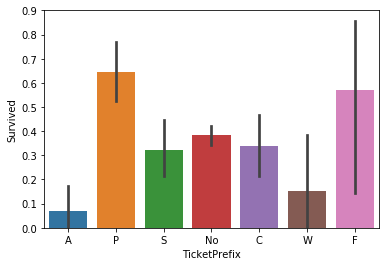

In [84]:
sns.barplot(x='TicketPrefix', y='Survived', data=train)

In [40]:
# ticket_dummies = pd.get_dummies(train.TicketPrefix)[['P', 'F']]
# ticket_dummies.columns = ['Ticket_P', 'Ticket_F']
# train = train.join(ticket_dummies)

# ticket_dummies = pd.get_dummies(train.TicketPrefix)[['P', 'F']]
# ticket_dummies.columns = ['Ticket_P', 'Ticket_F']
# test = test.join(ticket_dummies)

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,TicketPrefix
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,0,S,Mr,A
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,1,C,Mrs,P
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,0,S,Miss,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,1,S,Mrs,No
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,0,S,Mr,No


In [85]:
train['Alone'] = ((train.Parch + train.SibSp) == 0).astype(int)
test['Alone'] = ((test.Parch + test.SibSp) == 0).astype(int)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,TicketPrefix,Alone
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,0,S,Mr,A,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,1,C,Mrs,P,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,0,S,Miss,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,1,S,Mrs,No,0
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,0,S,Mr,No,1


In [86]:
train = train.drop(['Name', 'SibSp', 'Parch'], axis=1)
test = test.drop(['Name', 'SibSp', 'Parch'], axis=1)
train.head()

,PassengerId,Survived,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked,Title,TicketPrefix,Alone
0,1,0,3,1,22.0,A/5 21171,7.2500,0,S,Mr,A,0
1,2,1,1,0,38.0,PC 17599,71.2833,1,C,Mrs,P,0
2,3,1,3,0,26.0,STON/O2. 3101282,7.9250,0,S,Miss,S,1
3,4,1,1,0,35.0,113803,53.1000,1,S,Mrs,No,0
4,5,0,3,1,35.0,373450,8.0500,0,S,Mr,No,1


In [87]:
# train = train.drop(['Ticket'], axis=1)
# test = test.drop(['Ticket'], axis=1)
train.head()

,PassengerId,Survived,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked,Title,TicketPrefix,Alone
0,1,0,3,1,22.0,A/5 21171,7.2500,0,S,Mr,A,0
1,2,1,1,0,38.0,PC 17599,71.2833,1,C,Mrs,P,0
2,3,1,3,0,26.0,STON/O2. 3101282,7.9250,0,S,Miss,S,1
3,4,1,1,0,35.0,113803,53.1000,1,S,Mrs,No,0
4,5,0,3,1,35.0,373450,8.0500,0,S,Mr,No,1


In [88]:
train.TicketPrefix.unique()

array(['A', 'P', 'S', 'No', 'C', 'W', 'F'], dtype=object)

In [90]:
def encode_ticket(t):
    e = {
        'No': 0,
        'A': 1,
        'P': 2,
        'S': 3,
        'C': 4,
        'W': 5,
        'F': 6
    }
    return e.get(t, -1)

train['Ticket'] = train.TicketPrefix.apply(encode_ticket)
test['Ticket'] = test.TicketPrefix.apply(encode_ticket)
train.head()

,PassengerId,Survived,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked,Title,TicketPrefix,Alone
0,1,0,3,1,22.0,1,7.2500,0,S,Mr,A,0
1,2,1,1,0,38.0,2,71.2833,1,C,Mrs,P,0
2,3,1,3,0,26.0,3,7.9250,0,S,Miss,S,1
3,4,1,1,0,35.0,0,53.1000,1,S,Mrs,No,0
4,5,0,3,1,35.0,0,8.0500,0,S,Mr,No,1


In [91]:
train.Title = LabelEncoder().fit_transform(train.Title)
test.Title = LabelEncoder().fit_transform(test.Title)
train.head()

,PassengerId,Survived,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked,Title,TicketPrefix,Alone
0,1,0,3,1,22.0,1,7.2500,0,S,2,A,0
1,2,1,1,0,38.0,2,71.2833,1,C,3,P,0
2,3,1,3,0,26.0,3,7.9250,0,S,1,S,1
3,4,1,1,0,35.0,0,53.1000,1,S,3,No,0
4,5,0,3,1,35.0,0,8.0500,0,S,2,No,1


In [92]:
train.Embarked = LabelEncoder().fit_transform(train.Embarked)
test.Embarked = LabelEncoder().fit_transform(test.Embarked)
train.head()

,PassengerId,Survived,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked,Title,TicketPrefix,Alone
0,1,0,3,1,22.0,1,7.2500,0,2,2,A,0
1,2,1,1,0,38.0,2,71.2833,1,0,3,P,0
2,3,1,3,0,26.0,3,7.9250,0,2,1,S,1
3,4,1,1,0,35.0,0,53.1000,1,2,3,No,0
4,5,0,3,1,35.0,0,8.0500,0,2,2,No,1


In [93]:
train.drop(['TicketPrefix'], axis=1, inplace=True)
test.drop(['TicketPrefix'], axis=1, inplace=True)

In [94]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked,Title,Alone
0,1,0,3,1,22.0,1,7.2500,0,2,2,0
1,2,1,1,0,38.0,2,71.2833,1,0,3,0
2,3,1,3,0,26.0,3,7.9250,0,2,1,1
3,4,1,1,0,35.0,0,53.1000,1,2,3,0
4,5,0,3,1,35.0,0,8.0500,0,2,2,1


In [95]:
data = pd.concat([train, test])
data.drop(['Survived'], axis=1, inplace=True)
data.head()

,Age,Alone,Cabin,Embarked,Fare,PassengerId,Pclass,Sex,Ticket,Title
0,22.0,0,0,2,7.2500,1,3,1,1,2
1,38.0,0,1,0,71.2833,2,1,0,2,3
2,26.0,1,0,2,7.9250,3,3,0,3,1
3,35.0,0,1,2,53.1000,4,1,0,0,3
4,35.0,1,0,2,8.0500,5,3,1,0,2


In [96]:
data.drop(['PassengerId'], axis=1, inplace=True)

In [97]:
predictors = data[data.Age > 0]
predictors.drop(['Age'], axis=1, inplace=True)
targets = data[data.Age > 0].Age
predictors.shape, targets.shape

((1046, 8), (1046,))

In [98]:
predictors.head()

,Alone,Cabin,Embarked,Fare,Pclass,Sex,Ticket,Title
0,0,0,2,7.2500,3,1,1,2
1,0,1,0,71.2833,1,0,2,3
2,1,0,2,7.9250,3,0,3,1
3,0,1,2,53.1000,1,0,0,3
4,1,0,2,8.0500,3,1,0,2


In [99]:
predictors = StandardScaler().fit_transform(predictors)
x_train, x_test, y_train, y_test = train_test_split(predictors, targets, test_size = 0.22, random_state = 0)

In [100]:
mlp = MLPRegressor(hidden_layer_sizes=(143, ))
mlp.fit(x_train, y_train)
y_pred = mlp.predict(x_test)
mean_squared_error(y_pred, y_test), mean_squared_error(mlp.predict(x_train), y_train), mlp

(124.80616676358554,
 118.31026626765022,
 MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(143,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False))

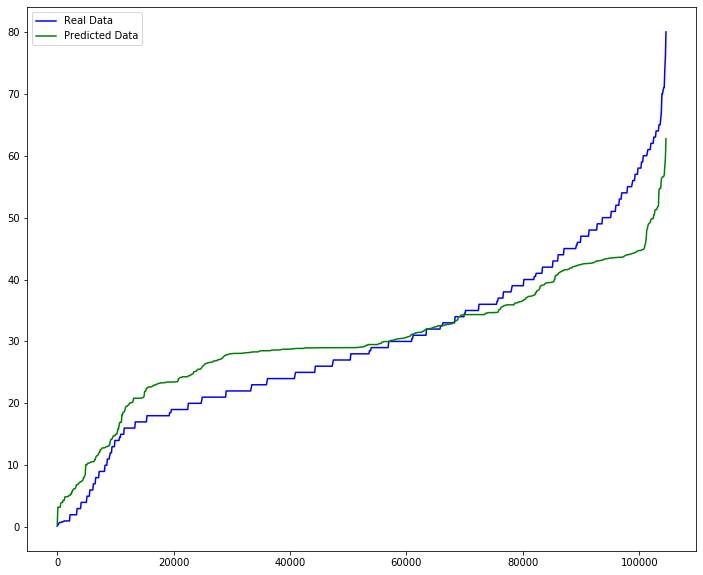

In [101]:
real_data = np.sort(np.concatenate((y_train, y_test)))
predicted_data = np.sort(np.concatenate((mlp.predict(x_train), mlp.predict(x_test))))

fig, ax = plt.subplots()
fig.set_size_inches(12, 10)

plt.plot(np.linspace(start=0, stop=len(real_data)*100, num=len(real_data)), real_data, color='b', label='Real Data')
plt.plot(np.linspace(start=0, stop=len(real_data)*100, num=len(real_data)), predicted_data, color='g', label='Predicted Data')

plt.legend()

In [104]:
train.loc[train.Age < 0, 'Age'] = mlp.predict(StandardScaler().fit_transform(train[train['Age'] < 0][['Alone', 'Cabin', 'Embarked', 'Fare',  'Pclass', 'Sex','Ticket', 'Title']]))

In [113]:
test.loc[test.Age < 0, 'Age'] = mlp.predict(StandardScaler().fit_transform(test[test['Age'] < 0][['Alone', 'Cabin', 'Embarked', 'Fare',  'Pclass', 'Sex','Ticket', 'Title']]))

In [115]:
test.loc[test.Age < 0, 'Age'] = 0.1
train.loc[train.Age < 0, 'Age'] = 0.1

train.head()

,PassengerId,Survived,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked,Title,Alone
0,1,0,3,1,22.0,1,7.2500,0,2,2,0
1,2,1,1,0,38.0,2,71.2833,1,0,3,0
2,3,1,3,0,26.0,3,7.9250,0,2,1,1
3,4,1,1,0,35.0,0,53.1000,1,2,3,0
4,5,0,3,1,35.0,0,8.0500,0,2,2,1


In [117]:
predictors = train.drop(['PassengerId', 'Survived'], axis=1)
targets = train[['Survived']]
predictors = StandardScaler().fit_transform(predictors)

In [141]:
x_train, x_test, y_train, y_test = train_test_split(predictors, targets, test_size = 0.05, random_state = 0)

In [140]:
mlp = MLPRegressor()
mlp.fit(x_train, y_train)

y_pred = mlp.predict(x_train).round()
test_pred = mlp.predict(x_test).round()

score = accuracy_score(y_train, y_pred)
test_score = accuracy_score(y_test, test_pred)

score, test_score

(0.8605442176870748, 0.8888888888888888)

In [138]:
ids = test['PassengerId']
predictions = np.abs(mlp.predict(StandardScaler().fit_transform(test.drop(['PassengerId'], axis=1))).round()).astype(int)

output = pd.DataFrame({ 'PassengerId' : ids, 'Survived': predictions })
output.to_csv('mlpsubmission.csv', index=False)